In [1]:
#!pip install yfinance

In [14]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from tensorflow.keras.optimizers.legacy import Adam

In [3]:
# System Constants
Epoch_count = 50
Batch_size = 32

In [4]:
walmart_price_data = yf.Ticker("WMT")
walmart_historical_data = walmart_price_data.history(period="max")

In [5]:
#Having a look at the closing price data of the stocks
# Get closing price column from the dataframe
closing_price_walmart = walmart_historical_data.iloc[:,3:4]
closing_price_walmart = closing_price_walmart.rename(columns={"Close": "Closing Price"})
closing_price_walmart.head()

,Closing Price
Date,
1972-08-25 00:00:00-04:00,0.035475
1972-08-28 00:00:00-04:00,0.035341
1972-08-29 00:00:00-04:00,0.034938
1972-08-30 00:00:00-04:00,0.034938
1972-08-31 00:00:00-04:00,0.034400


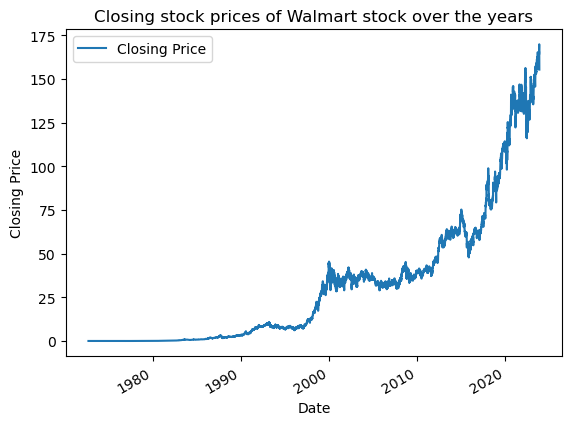

In [6]:
# Plotting the closing stock price data
closing_price_walmart.plot()
plt.ylabel("Closing Price")
plt.title("Closing stock prices of Walmart stock over the years")
plt.show()

In [7]:
# Scale the data using Min-Max scaling to reduce computational cost.
scaler = MinMaxScaler()
closing_price_walmart_scaled = scaler.fit_transform(closing_price_walmart)

# The following logical comparison concludes that there are no NaN values.
len(closing_price_walmart.isna()) == len(closing_price_walmart)
closing_price_walmart_scaled_df = pd.DataFrame(closing_price_walmart_scaled)
closing_price_walmart_scaled_df.index = closing_price_walmart.index
closing_price_walmart_scaled_df = closing_price_walmart_scaled_df.rename(columns={0:"Closing Price"})
closing_price_walmart_scaled_df.head()

,Closing Price
Date,
1972-08-25 00:00:00-04:00,0.000158
1972-08-28 00:00:00-04:00,0.000157
1972-08-29 00:00:00-04:00,0.000155
1972-08-30 00:00:00-04:00,0.000155
1972-08-31 00:00:00-04:00,0.000152


In [8]:
def get_data_splits(data, train_size=20, label_count=1):
    
    # Initialize empty arrays for training sets and labels
    train_sets = np.empty((0, train_size))
    labels = np.empty((0, label_count))

    # Calculate the length of the input data
    length = len(data)

    # Iterate through the data to create training sets and labels
    for i in range(0, length):
        # Check if extending the current index by train_size exceeds the data length
        if (i + train_size) >= length:
            break

        # Append a reshaped training sequence to the train_sets array
        train_sequence = data[i:(i + train_size)].reshape(train_size,)
        train_sets = np.append(train_sets, [train_sequence], axis=0)

        # Append the corresponding label sequence to the labels array
        label_sequence = data[(i + train_size):(i + train_size + label_count)].reshape(label_count,)
        labels = np.append(labels, [label_sequence], axis=0)

    # Reshape the arrays for compatibility with machine learning models
    reshaped_train_sets = train_sets.reshape(len(train_sets), train_size, 1)
    reshaped_labels = labels.reshape(len(labels), label_count, 1)

    return reshaped_train_sets, reshaped_labels

In [9]:
# Splitting the dataset
length = len(closing_price_walmart_scaled)
train_sample_count = round(0.60 * length)
remaining_sample_count = length - train_sample_count
val_sample_count = round(0.50 * remaining_sample_count)

training_walmart = closing_price_walmart_scaled[0:train_sample_count]
validation_walmart = closing_price_walmart_scaled[train_sample_count:(
    train_sample_count + val_sample_count)]
testing_walmart = closing_price_walmart_scaled[(
    train_sample_count + val_sample_count):length]

In [10]:
len(training_walmart), len(validation_walmart), len(testing_walmart)

(7752, 2584, 2584)

In [11]:
# Get the train features, train labels, test features, test labels
train_size = 20
label_count = 1
X_train, y_train = get_data_splits(training_walmart, train_size, label_count)
X_val, y_val = get_data_splits(validation_walmart, train_size, label_count)
X_test, y_test = get_data_splits(testing_walmart, train_size, label_count)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

7732 7732
2564 2564
2564 2564


In [12]:
def plot_training_history_curve(fitted_model):
    """Plot training/validation loss and accuracy curve."""
    history_df = pd.DataFrame(fitted_model.history)
    history_df.plot()
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss - Accuracy")
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted_values(y_train, y_test, train_predict, test_predict):
    """Plot actual and predicted values."""
    actual = np.append(y_train, y_test)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)

    plt.figure(figsize=(15, 8), dpi=80)
    plt.plot(range(rows), actual, label='Actual')
    plt.plot(range(rows), predictions, label='Predictions')
    plt.axvline(x=len(y_train), color='r')
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Closing Stock price')
    plt.title('Actual and Predicted values with the red line separating Training And Test examples')
    plt.show()

### Baseline LSTM Creation

In [15]:
def create_base_lstm(hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(learning_rate=lr))
    return model

n_hidden_units = 64
n_dense_units = 1
input_shape = (train_size, 1)

# Create base LSTM
base_lstm = create_base_lstm(n_hidden_units, n_dense_units, input_shape, activation='tanh')
base_lstm.summary()

# Training the base LSTM
with tf.device('/cpu:0'):
    fitted_base_lstm = base_lstm.fit(X_train, y_train, validation_data=(X_val, y_val),
                                    batch_size=Batch_size, epochs=Epoch_count)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
242/242 [==============================] - 1s 4ms/step - loss: 2.4488e-04 - val_loss: 3.4822e-05
Epoch 2/50
242/242 [==============================] - 1s 3ms/step - loss: 1.4438e-05 - val_loss: 3.0639e-05
Epoch 3/50
242/242 [==============================] - 1s 3ms/step - loss: 1.3919e-05 - val_loss: 3.6282e-05
Epoch 4/50
242/242 [==============================] - 1s 3ms/step - loss: 1.2459e-05 - val

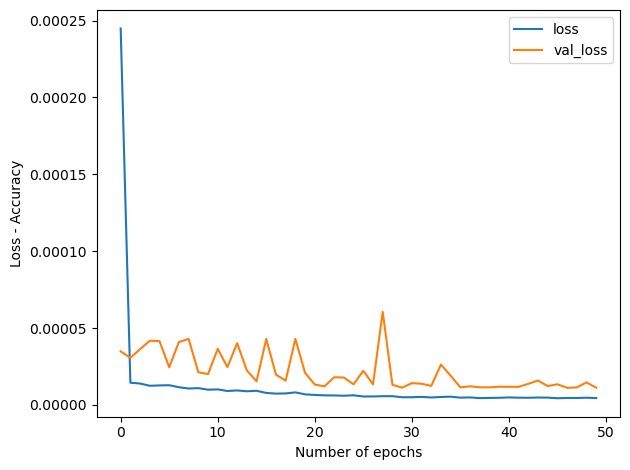

In [16]:
plot_training_history_curve(fitted_base_lstm)

81/81 [==============================] - 0s 906us/step


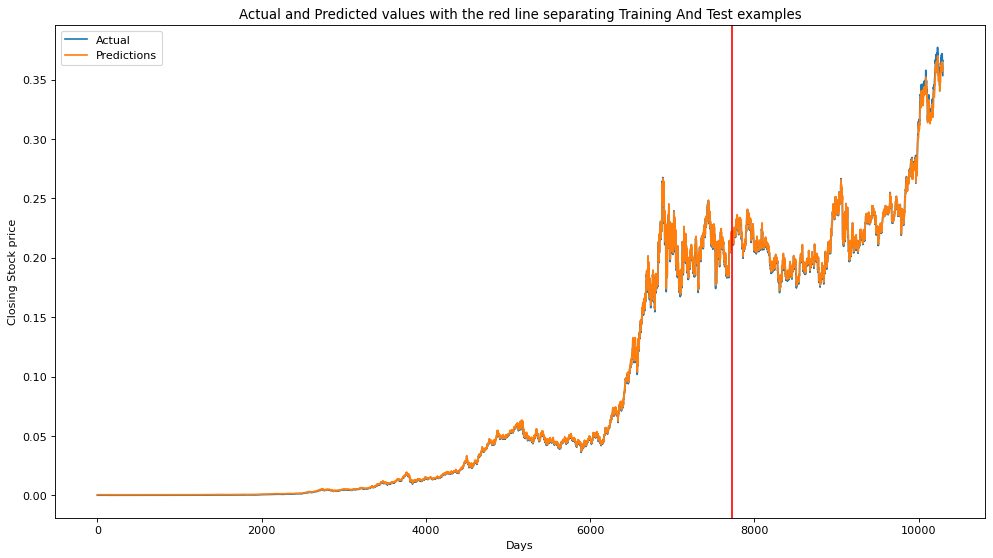

In [17]:
# Predictions using the trained base LSTM model
with tf.device('/cpu:0'):
    train_predictions_base_lstm = fitted_base_lstm.model.predict(X_train)
    val_predictions_base_lstm = fitted_base_lstm.model.predict(X_val)

# Plotting actual stock prices and predictions
plot_actual_vs_predicted_values(y_train, y_val, train_predictions_base_lstm, val_predictions_base_lstm)

### Experimentation on base LSTM

In [18]:
# Adding more layers

# Creating RNN with multiple layers
def create_multilayered_lstm(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(LSTM(hidden_units_list[0], input_shape=input_shape, activation=activation, return_sequences=True))
    
    for i in range(1, len(hidden_units_list)):
        if i == len(hidden_units_list) - 1:
            model.add(LSTM(hidden_units_list[i], activation=activation, return_sequences=False))
        else:
            model.add(LSTM(hidden_units_list[i], activation=activation, return_sequences=True))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(learning_rate=lr))
    return model

n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (train_size, 1)

multilayered_lstm = create_multilayered_lstm(n_hidden_units_list, n_dense_units, input_shape, activation='tanh')
multilayered_lstm.summary()

# Training the RNN with multiple LSTM layers
with tf.device('/cpu:0'):
    fitted_multilayered_lstm = multilayered_lstm.fit(X_train, y_train, validation_data=(X_val, y_val),
                                                    batch_size=Batch_size, epochs=Epoch_count)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20, 64)            16896     
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83009 (324.25 KB)
Trainable params: 83009 (324.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
242/242 [==============================] - 4s 12ms/step - loss: 1.0470e-04 - val_loss: 1.0074e-04
Epoch 2/50
242/242 [===================

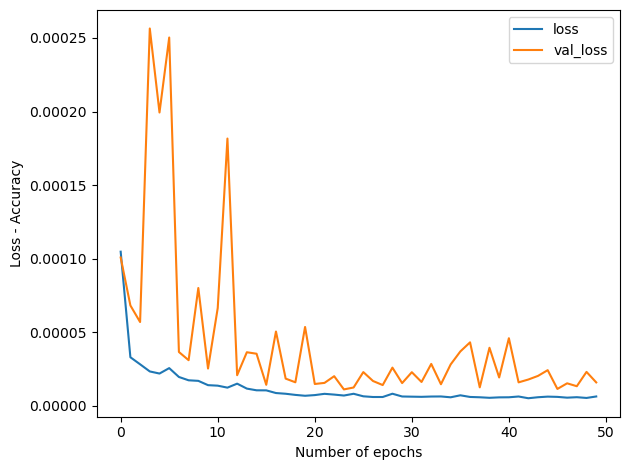

In [19]:
plot_training_history_curve(fitted_multilayered_lstm)

81/81 [==============================] - 0s 3ms/step


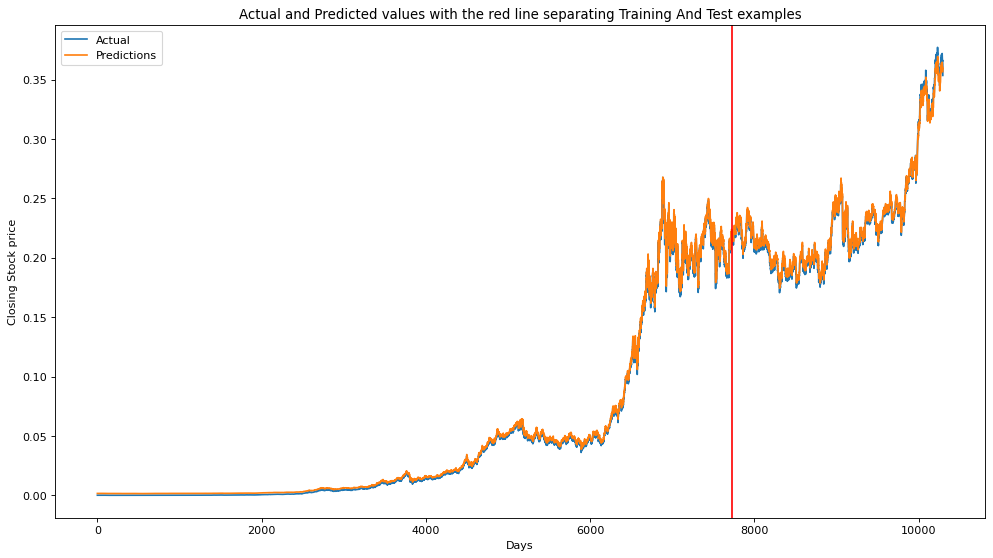

In [21]:
# Predictions using the trained multilayered LSTM model
with tf.device('/cpu:0'):
    train_predictions_multilayered_lstm = fitted_multilayered_lstm.model.predict(X_train)
    val_predictions_multilayered_lstm = fitted_multilayered_lstm.model.predict(X_val)

# Plotting actual stock prices and predictions
plot_actual_vs_predicted_values(y_train, y_val, train_predictions_multilayered_lstm, val_predictions_multilayered_lstm)

In [ ]:
# Experimenting with activation function and learning rate scheduling techniques

In [23]:
def create_lstm_with_optimizer(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    if optimizer == "Adam":
        optimizing_function = keras.optimizers.legacy.Adam()
    else:
        optimizing_function = keras.optimizers.legacy.RMSprop()

    model.compile(loss='mean_squared_error', optimizer=optimizing_function)
    return model

initial_learning_rate = 0.01
time_decay = initial_learning_rate / Epoch_count

def step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

callbacks_decay = [
    keras.callbacks.LearningRateScheduler(step_decay, verbose=1),
    keras.callbacks.LearningRateScheduler(exp_decay, verbose=1)
]

callback_decay_keys = ["constant", "step_decay", "exp_decay"]

In [24]:
# Running the simple LSTM model with RMSProp and Adam with 3 different types of learning rate scheduling.
n_hidden_units = 64
n_dense_units = 1
results_simple_lstm = []
optimizers = ["Adam", "RMSProp"]

for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        lstm_model = create_lstm_with_optimizer(n_hidden_units, n_dense_units,
                                                input_shape, activation='tanh', optimizer=optimizer)

        # Training the LSTM model with learning rate scheduling
        with tf.device('/cpu:0'):
            if i == 0:
                fitted_lstm_model = lstm_model.fit(X_train, y_train, validation_data=(
                    X_val, y_val), batch_size=Batch_size, epochs=Epoch_count)
            else:
                fitted_lstm_model = lstm_model.fit(X_train, y_train, validation_data=(
                    X_val, y_val), batch_size=Batch_size, epochs=Epoch_count, callbacks=[callbacks_decay[i - 1]])

        # Predictions on validation data
        predictions = fitted_lstm_model.model.predict(X_val)

        # Calculate validation MSE
        val_mse = mean_squared_error(y_val.reshape(y_val.shape[0], 1), predictions)

        # Append results to the list
        results_simple_lstm.append((optimizer, callback_decay_keys[i], val_mse))

Epoch 1/50
242/242 [==============================] - 1s 4ms/step - loss: 1.4691e-04 - val_loss: 2.9448e-05
Epoch 2/50
242/242 [==============================] - 1s 3ms/step - loss: 1.2963e-05 - val_loss: 2.7348e-05
Epoch 3/50
242/242 [==============================] - 1s 3ms/step - loss: 1.2637e-05 - val_loss: 5.5033e-05
Epoch 4/50
242/242 [==============================] - 1s 3ms/step - loss: 1.1449e-05 - val_loss: 2.6050e-05
Epoch 5/50
242/242 [==============================] - 1s 3ms/step - loss: 1.1819e-05 - val_loss: 7.9613e-05
Epoch 6/50
242/242 [==============================] - 1s 3ms/step - loss: 1.1169e-05 - val_loss: 5.4355e-05
Epoch 7/50
242/242 [==============================] - 1s 3ms/step - loss: 1.0900e-05 - val_loss: 9.0809e-05
Epoch 8/50
242/242 [==============================] - 1s 3ms/step - loss: 9.5824e-06 - val_loss: 2.0577e-05
Epoch 9/50
242/242 [==============================] - 1s 3ms/step - loss: 9.0776e-06 - val_loss: 2.1590e-05
Epoch 10/50
242/242 [=======


Epoch 8: LearningRateScheduler setting learning rate to 0.004965853037914095.
Epoch 8/50
242/242 [==============================] - 1s 3ms/step - loss: 6.7403e-06 - val_loss: 1.9021e-05 - lr: 0.0050

Epoch 9: LearningRateScheduler setting learning rate to 0.004493289641172216.
Epoch 9/50
242/242 [==============================] - 1s 3ms/step - loss: 6.7381e-06 - val_loss: 1.3977e-05 - lr: 0.0045

Epoch 10: LearningRateScheduler setting learning rate to 0.004065696597405992.
Epoch 10/50
242/242 [==============================] - 1s 3ms/step - loss: 6.4092e-06 - val_loss: 1.6281e-05 - lr: 0.0041

Epoch 11: LearningRateScheduler setting learning rate to 0.0036787944117144234.
Epoch 11/50
242/242 [==============================] - 1s 3ms/step - loss: 6.9029e-06 - val_loss: 2.4059e-05 - lr: 0.0037

Epoch 12: LearningRateScheduler setting learning rate to 0.003328710836980796.
Epoch 12/50
242/242 [==============================] - 1s 3ms/step - loss: 5.7508e-06 - val_loss: 1.1806e-05 - lr: 


Epoch 48: LearningRateScheduler setting learning rate to 9.095277101695816e-05.
Epoch 48/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8765e-06 - val_loss: 1.3145e-05 - lr: 9.0953e-05

Epoch 49: LearningRateScheduler setting learning rate to 8.229747049020023e-05.
Epoch 49/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8625e-06 - val_loss: 1.0864e-05 - lr: 8.2297e-05

Epoch 50: LearningRateScheduler setting learning rate to 7.446583070924338e-05.
Epoch 50/50
81/81 [==============================] - 0s 959us/step
Epoch 1/50
242/242 [==============================] - 1s 4ms/step - loss: 1.1536e-04 - val_loss: 2.2559e-04
Epoch 2/50
242/242 [==============================] - 1s 3ms/step - loss: 3.7440e-05 - val_loss: 3.0534e-04
Epoch 3/50
242/242 [==============================] - 1s 3ms/step - loss: 2.8296e-05 - val_loss: 8.8780e-05
Epoch 4/50
242/242 [==============================] - 1s 3ms/step - loss: 2.4526e-05 - val_loss: 2.2136e-04
Epoch 


Epoch 12: LearningRateScheduler setting learning rate to 0.005.
Epoch 12/50
242/242 [==============================] - 1s 3ms/step - loss: 1.8895e-05 - val_loss: 3.4099e-05 - lr: 0.0050

Epoch 13: LearningRateScheduler setting learning rate to 0.005.
Epoch 13/50
242/242 [==============================] - 1s 3ms/step - loss: 1.8434e-05 - val_loss: 2.5574e-05 - lr: 0.0050

Epoch 14: LearningRateScheduler setting learning rate to 0.005.
Epoch 14/50
242/242 [==============================] - 1s 3ms/step - loss: 1.8269e-05 - val_loss: 4.8095e-05 - lr: 0.0050

Epoch 15: LearningRateScheduler setting learning rate to 0.005.
Epoch 15/50
242/242 [==============================] - 1s 3ms/step - loss: 1.8786e-05 - val_loss: 2.1388e-05 - lr: 0.0050

Epoch 16: LearningRateScheduler setting learning rate to 0.005.
Epoch 16/50
242/242 [==============================] - 1s 3ms/step - loss: 1.7907e-05 - val_loss: 5.6378e-05 - lr: 0.0050

Epoch 17: LearningRateScheduler setting learning rate to 0.005.



Epoch 5: LearningRateScheduler setting learning rate to 0.006703200460356393.
Epoch 5/50
242/242 [==============================] - 1s 3ms/step - loss: 4.9483e-05 - val_loss: 9.7063e-05 - lr: 0.0067

Epoch 6: LearningRateScheduler setting learning rate to 0.006065306597126334.
Epoch 6/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8198e-05 - val_loss: 5.0815e-05 - lr: 0.0061

Epoch 7: LearningRateScheduler setting learning rate to 0.005488116360940264.
Epoch 7/50
242/242 [==============================] - 1s 3ms/step - loss: 3.1677e-05 - val_loss: 8.9819e-05 - lr: 0.0055

Epoch 8: LearningRateScheduler setting learning rate to 0.004965853037914095.
Epoch 8/50
242/242 [==============================] - 1s 3ms/step - loss: 2.5768e-05 - val_loss: 1.1579e-04 - lr: 0.0050

Epoch 9: LearningRateScheduler setting learning rate to 0.004493289641172216.
Epoch 9/50
242/242 [==============================] - 1s 3ms/step - loss: 2.0618e-05 - val_loss: 1.0200e-04 - lr: 0.0045


Epoch 45/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8715e-06 - val_loss: 2.0618e-05 - lr: 1.2277e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.00011108996538242307.
Epoch 46/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8605e-06 - val_loss: 1.8846e-05 - lr: 1.1109e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.00010051835744633576.
Epoch 47/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8382e-06 - val_loss: 1.7715e-05 - lr: 1.0052e-04

Epoch 48: LearningRateScheduler setting learning rate to 9.095277101695816e-05.
Epoch 48/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8389e-06 - val_loss: 1.6361e-05 - lr: 9.0953e-05

Epoch 49: LearningRateScheduler setting learning rate to 8.229747049020023e-05.
Epoch 49/50
242/242 [==============================] - 1s 3ms/step - loss: 3.8316e-06 - val_loss: 1.8499e-05 - lr: 8.2297e-05

Epoch 50: LearningRateScheduler setting lea

In [30]:
columns = ["Optimizer", "Decay type", "Val MSE"]
lstm_results_dataframe = pd.DataFrame(results_simple_lstm, columns=columns)
lstm_results_dataframe

,Optimizer,Decay type,Val MSE
0,Adam,constant,0.000011
1,Adam,step_decay,0.000013
2,Adam,exp_decay,0.000012
3,RMSProp,constant,0.000015
4,RMSProp,step_decay,0.000022
5,RMSProp,exp_decay,0.000018


In [27]:
# Based on the above results, Adam with either constant learning rate or exp_decay or step_decay is the best one

# Create LSTM model with constant learning rate
optimized_lstm_constant_lr = create_lstm_with_optimizer(n_hidden_units, n_dense_units, input_shape, activation='tanh', optimizer=keras.optimizers.legacy.Adam())
optimized_lstm_constant_lr.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(learning_rate=initial_learning_rate))

# Training the LSTM model with constant learning rate
with tf.device('/cpu:0'):
    fitted_optimized_lstm_constant_lr = optimized_lstm_constant_lr.fit(X_train, y_train, validation_data=(X_val, y_val),
                                                                      batch_size=Batch_size, epochs=Epoch_count)


Epoch 1/50
242/242 [==============================] - 1s 4ms/step - loss: 1.7631e-04 - val_loss: 2.5616e-05
Epoch 2/50
242/242 [==============================] - 1s 3ms/step - loss: 1.0994e-05 - val_loss: 2.8794e-05
Epoch 3/50
242/242 [==============================] - 1s 3ms/step - loss: 1.0791e-05 - val_loss: 1.5195e-05
Epoch 4/50
242/242 [==============================] - 1s 3ms/step - loss: 1.0682e-05 - val_loss: 5.1846e-05
Epoch 5/50
242/242 [==============================] - 1s 3ms/step - loss: 1.0393e-05 - val_loss: 1.5596e-05
Epoch 6/50
242/242 [==============================] - 1s 3ms/step - loss: 8.7693e-06 - val_loss: 2.6005e-05
Epoch 7/50
242/242 [==============================] - 1s 3ms/step - loss: 9.2234e-06 - val_loss: 1.6228e-05
Epoch 8/50
242/242 [==============================] - 1s 3ms/step - loss: 6.9883e-06 - val_loss: 1.9477e-05
Epoch 9/50
242/242 [==============================] - 1s 3ms/step - loss: 7.5316e-06 - val_loss: 1.2282e-05
Epoch 10/50
242/242 [=======

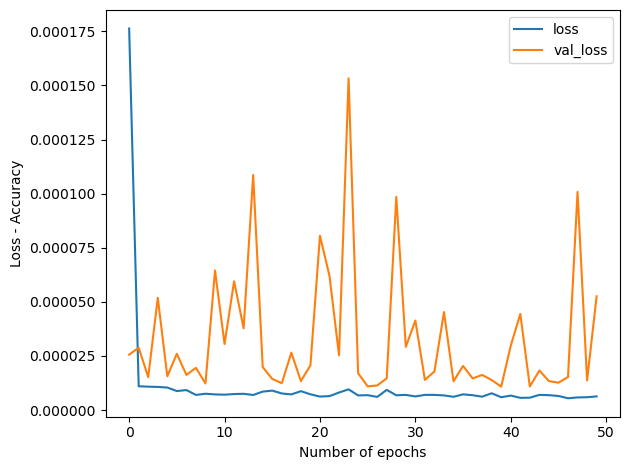

In [29]:
plot_training_history_curve(fitted_optimized_lstm_constant_lr)

81/81 [==============================] - 0s 905us/step


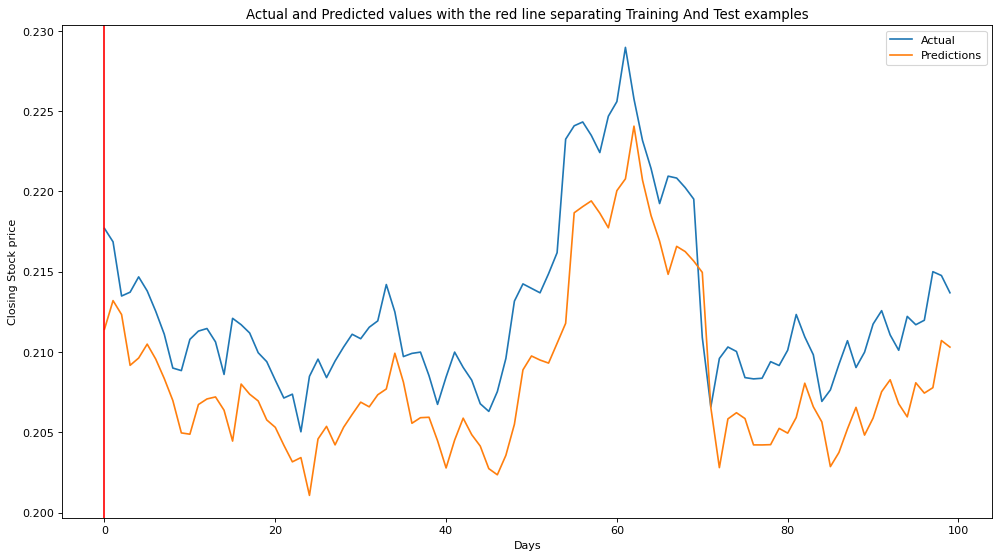

In [32]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predictions_optimized_lstm_constant_lr = fitted_optimized_lstm_constant_lr.model.predict(X_train)
    val_predictions_optimized_lstm_constant_lr = fitted_optimized_lstm_constant_lr.model.predict(X_val)

# plot_result(y_train, y_val, train_predictions_optimized_lstm_constant_lr, val_predictions_optimized_lstm_constant_lr)
plot_actual_vs_predicted_values(np.array([]), y_val[300:400], np.array([]), val_predictions_optimized_lstm_constant_lr[300:400])


In [35]:
# Performance Metrics

# Get training and validation MSEs for all variations of the LSTM
train_mse_base_lstm, val_mse_base_lstm = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predictions_base_lstm), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predictions_base_lstm)

train_mse_multilayered_lstm, val_mse_mulilayered_lstm = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predictions_multilayered_lstm), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predictions_multilayered_lstm)

train_mse_optimized_lstm_constant_lr, val_mse_optimized_lstm_constant_lr = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predictions_optimized_lstm_constant_lr), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predictions_optimized_lstm_constant_lr)


In [36]:
# Define a list of tuples for RNN summary
summary_list_lstm = [
    ("Base LSTM", train_mse_base_lstm, val_mse_base_lstm),
    ("Stacked LSTM", train_mse_multilayered_lstm, val_mse_mulilayered_lstm),
    ("Optimized LSTM", train_mse_optimized_lstm_constant_lr, val_mse_optimized_lstm_constant_lr)
]

# Create a DataFrame for RNN summary
summary_dataframe = pd.DataFrame(summary_list_lstm, columns=["Model", "Train MSE", "Val MSE"])
summary_dataframe

,Model,Train MSE,Val MSE
0,Base LSTM,0.000004,0.000011
1,Stacked LSTM,0.000007,0.000016
2,Optimized LSTM,0.000007,0.000053


(7702, 50, 1) (7702, 1, 1)
(2534, 50, 1) (2534, 1, 1)
Epoch 1/50
241/241 [==============================] - 8s 27ms/step - loss: 1.4043e-04 - val_loss: 1.0591e-04
Epoch 2/50
241/241 [==============================] - 6s 27ms/step - loss: 2.7499e-05 - val_loss: 5.8899e-05
Epoch 3/50
241/241 [==============================] - 6s 27ms/step - loss: 2.8086e-05 - val_loss: 1.1755e-04
Epoch 4/50
241/241 [==============================] - 7s 27ms/step - loss: 2.0899e-05 - val_loss: 6.2538e-05
Epoch 5/50
241/241 [==============================] - 7s 27ms/step - loss: 1.9415e-05 - val_loss: 5.7217e-05
Epoch 6/50
241/241 [==============================] - 7s 27ms/step - loss: 1.8613e-05 - val_loss: 3.8568e-05
Epoch 7/50
241/241 [==============================] - 7s 27ms/step - loss: 1.8193e-05 - val_loss: 5.2734e-05
Epoch 8/50
241/241 [==============================] - 7s 27ms/step - loss: 1.8446e-05 - val_loss: 3.4846e-05
Epoch 9/50
241/241 [==============================] - 7s 28ms/step - loss:

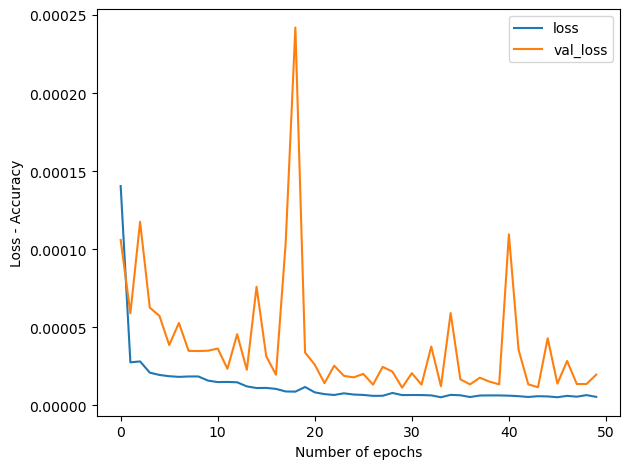

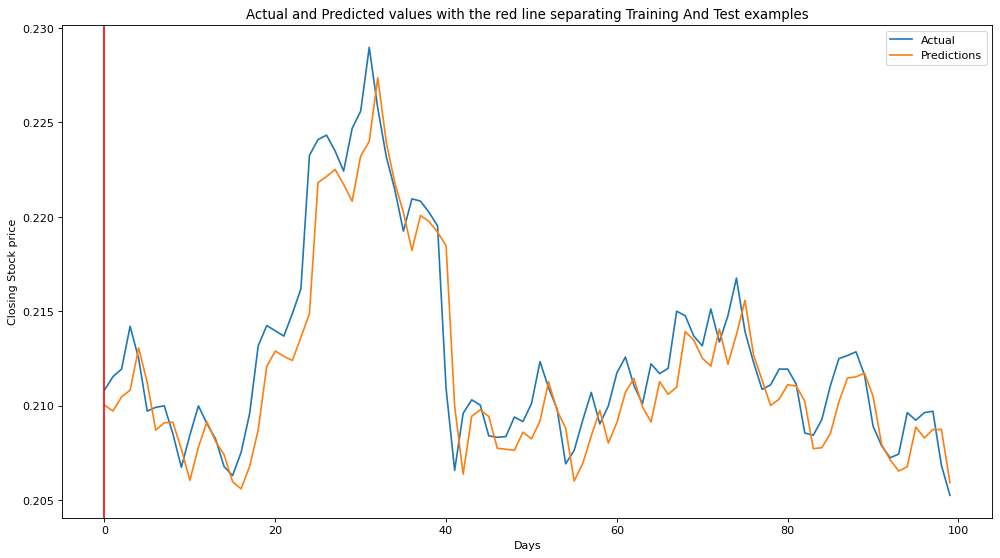

Val MSE = 1.9620196826956177e-05
(7652, 100, 1) (7652, 1, 1)
(2484, 100, 1) (2484, 1, 1)
Epoch 1/50
240/240 [==============================] - 15s 56ms/step - loss: 1.6763e-04 - val_loss: 6.0934e-05
Epoch 2/50
240/240 [==============================] - 14s 56ms/step - loss: 2.3840e-05 - val_loss: 2.2010e-04
Epoch 3/50
240/240 [==============================] - 14s 57ms/step - loss: 2.3229e-05 - val_loss: 9.4916e-05
Epoch 4/50
240/240 [==============================] - 14s 58ms/step - loss: 2.5914e-05 - val_loss: 3.7153e-04
Epoch 5/50
240/240 [==============================] - 14s 58ms/step - loss: 2.2812e-05 - val_loss: 4.3409e-05
Epoch 6/50
240/240 [==============================] - 13s 55ms/step - loss: 1.8086e-05 - val_loss: 3.7653e-05
Epoch 7/50
240/240 [==============================] - 13s 55ms/step - loss: 1.6735e-05 - val_loss: 3.9120e-05
Epoch 8/50
240/240 [==============================] - 13s 56ms/step - loss: 1.6833e-05 - val_loss: 4.4715e-05
Epoch 9/50
240/240 [===========

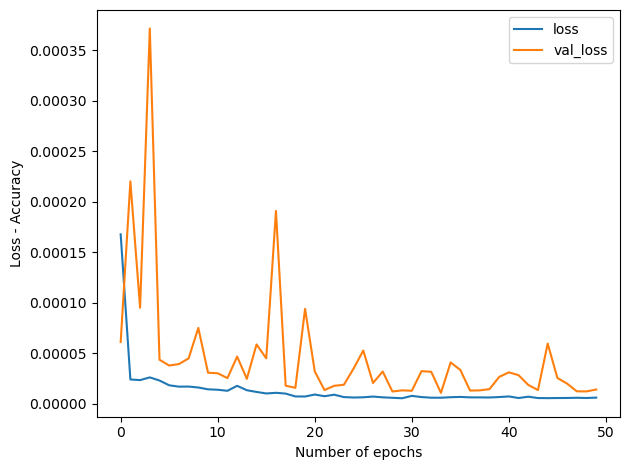

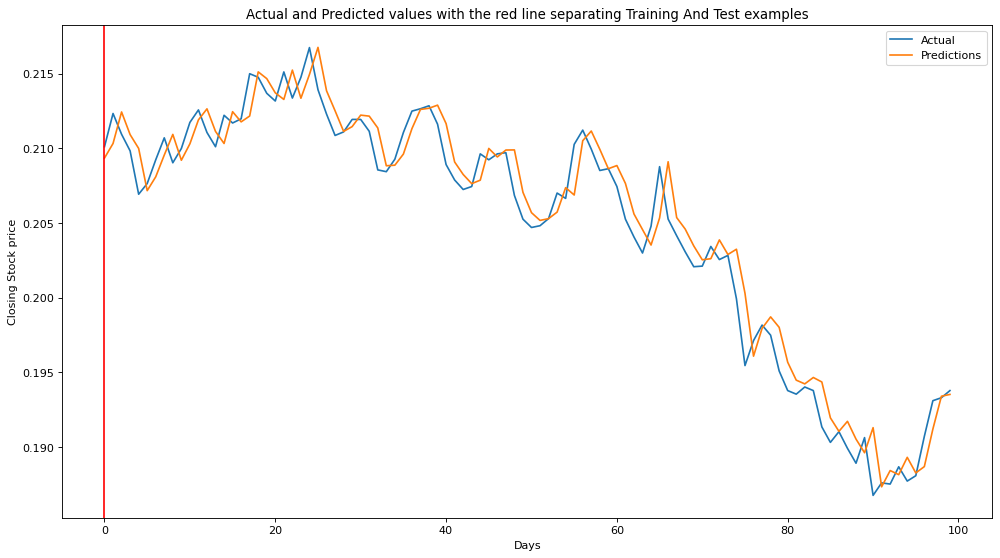

Val MSE = 1.3935899926963017e-05


In [37]:
# Experimenting with window size
# Get the train features, train labels, test features, test labels
train_sizes = [50, 100]
label_count = 1

for train_size in train_sizes:
    X_train_exp, y_train_exp = get_data_splits(
        training_walmart, train_size, label_count)
    X_val_exp, y_val_exp = get_data_splits(
        validation_walmart, train_size, label_count)
    
    #display data shapes
    print(X_train_exp.shape, y_train_exp.shape)
    print(X_val_exp.shape, y_val_exp.shape)

    # Create and train RNN model
    model_exp = create_multilayered_lstm([n_hidden_units, n_hidden_units, n_hidden_units], n_dense_units,
                              (train_size, 1), activation='tanh')
    with tf.device('/cpu:0'):
        # Train the model
        fitted_model_exp = model_exp.fit(X_train_exp, y_train_exp, validation_data=(
            X_val_exp, y_val_exp), batch_size=Batch_size, epochs=Epoch_count)
        # Predictions on train and validation data
        train_predict_exp = fitted_model_exp.model.predict(X_train_exp)
        val_predict_exp = fitted_model_exp.model.predict(X_val_exp)
    # Plotting actual stock prices and predictions
    plot_training_history_curve(fitted_model_exp)
    plot_actual_vs_predicted_values(np.array([]), y_val_exp[300:400],
                np.array([]), val_predict_exp[300:400])
    # Calculate and display validation MSE
    print("Val MSE =", mean_squared_error(
        y_val_exp.reshape(y_val_exp.shape[0], 1), val_predict_exp))